# Peak Correlations

In [1]:
import numpy as np
import random
import math
import seaborn
import statistics as stat
import matplotlib
from matplotlib import gridspec
import matplotlib.pyplot as plt
import scipy as scp
import scipy.optimize as sco
import scipy.signal as scs
import scipy.special as ssp
import scipy.integrate as sci
from labellines import labelLines
from collections import OrderedDict
from itertools import zip_longest, groupby, cycle
from numpy.random import seed, randn
from scipy import stats
from scipy.stats import shapiro, normaltest, anderson
from statsmodels.graphics.gofplots import qqplot
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib import ticker
import matplotlib.colors as mcolors

np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

### Simulation Parameters 

In [2]:
nLat = 8192
nTime = 256
nSims = 1000
minSim = 0
simstep = 1

lamb = 1. + 0.5; print('lamb = ', lamb)
phi0 = 2.*np.pi / 7.; print('phi0 = ', phi0)

nu = 2.*10**(-3)
lenLat = 8 * 0.5 * 50. / np.sqrt(2. * nu); print('lenLat = ', lenLat)
m2eff = 4. * nu * (- 1. + lamb**2); print('m2eff = ', m2eff)

alpha = 16.
phi_initial = np.pi

nyq = nLat//2+1; spec = nyq//16; dx = lenLat/nLat; dk = 2.*np.pi/lenLat; print('dx, dk, spec = ', dx,dk,spec)
dt = dx/alpha; dtout = dt*nLat/nTime; print('dtout/dt = ', dtout/dt)
light_cone = dtout/dx
unit_conv = nLat/nTime/alpha; print('units = ', unit_conv)

lamb =  1.5
phi0 =  0.8975979010256552
lenLat =  3162.2776601683795
m2eff =  0.01
dx, dk, spec =  0.3860202221885229 0.0019869176531592202 256
dtout/dt =  32.0
units =  2.0


filter_size =  4.542813258696356


Text(0, 0.5, '$\\phi$')

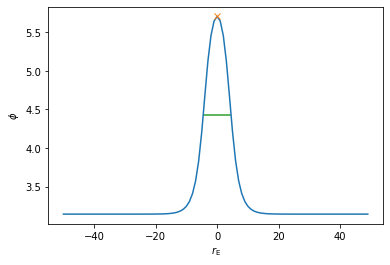

In [3]:
instanton_location = '/home/dpirvu/inst/unstable/dev/thick_wall_instanton_interp.dat'
a = np.genfromtxt(instanton_location)
coleman_bubble = 2*np.pi-a[:,1]
xoffset = 50
temp = coleman_bubble[len(coleman_bubble)//2-xoffset:len(coleman_bubble)//2+xoffset]
tempcoords = a[len(coleman_bubble)//2-xoffset:len(coleman_bubble)//2+xoffset,0]
peaks, _ = scs.find_peaks(temp)
fwhm = scs.peak_widths(temp, peaks, rel_height=0.5)
radius_Coleman_bubble = max(fwhm[0])/2.
filter_size = radius_Coleman_bubble
print('filter_size = ', filter_size)

plt.plot(tempcoords/dx, temp)
plt.plot(peaks-xoffset, temp[peaks], "x")
[plt.hlines(fwhm[1][i], fwhm[2][i]-xoffset, fwhm[3][i]-xoffset, color="C2") for i in range(len(fwhm[1]))]
plt.xlabel(r'$r_{\rm E}$'); plt.ylabel(r'$\phi$')

### Get Data 

In [4]:
plots_file = '/home/dpirvu/big_plot_file/bubble_correlations/free_'
suffix = '_for_phi0{:.4f}'.format(phi0)+'_len{:.4f}'.format(lenLat)+'_lamb{:.4f}'.format(lamb)+'_t'+str(nTime)+'_x'+str(nLat)

def sim_location(sim):
    return '/gpfs/dpirvu/bubble_correlations/free_t'+str(nTime)+'_x'+str(nLat)+'_len{:.4f}'.format(lenLat)+'_phi0{:.4f}'.format(phi0)+'_lamb{:.4f}'.format(lamb)+'_alph{:.4f}'.format(alpha)+'_spec'+str(spec)+'_sim'+str(sim)+'_fields.dat'

def targets_file(min, max):
    return '/home/dpirvu/pickle_location/bubble_correlations/free_free_targets_sims'+str(min)+'_to'+str(max)+suffix+'.npy'
def data_file_1d(max, Tmid):
    return '/home/dpirvu/pickle_location/bubble_correlations/1d_free_xmax'+str(max)+'_time'+str(Tmid)+'.npy'
def data_file_2d(max):
    return '/home/dpirvu/pickle_location/bubble_correlations/2d_free_xmax'+str(max)+'.npy'

def extract(filename, col):
    infile = open(filename,'r')
    lines = infile.readlines()
    field_values = [float(line.split()[col]) for line in lines[3:]]
    infile.close()
    return field_values

def all_data():
    data = []
    for sim in range(minSim, nSims, simstep):
        if sim == nSims // 2:
            print('Halfway through.')
        data.append(np.reshape(extract(sim_location(sim), 0), (nTime, nLat)))
    print('Done.')
    return data, np.arange(len(data))

def smoothen(field_slice, sigma):
    pbc = [j-1 if j < nLat/2+1 else nLat-j+1 for j in range(1, nLat+1)]
    window = [np.exp(- 0.5 * (x*dx/sigma)**2) / np.sqrt(2*np.pi) / (sigma/dx) for x in pbc]
    window = window / sum(window)
    spectral_filter = np.fft.fft(window, len(field_slice))

    fft_field_slice = np.fft.fft(field_slice, len(field_slice))
    smooth_fft_field_slice = [spectral_filter[k] * fft_field_slice[k] for k in range(len(fft_field_slice))]
    smooth_field_slice = np.fft.ifft(smooth_fft_field_slice, len(field_slice))
    return np.asarray([i.real for i in smooth_field_slice])

def find_peak_positions(slice, threshold):
    """ Finds x coordinate of peaks in masked field with mask applied at threshold. """
    peak_coord = scs.find_peaks(slice, height = threshold)[0].tolist()
    if slice[-1] >= threshold and slice[0] >= threshold and slice[-1] != slice[0]:
        if slice[0] > slice[-1] and slice[0] > slice[1]:
            peak_coord.append(0)
        elif slice[0] < slice[-1] and slice[-1] > slice[-2]:
            peak_coord.append(len(slice)-1) # this minds potential boundary discontinuities
    return np.asarray(peak_coord)

def get_peak_coords(data, threshold):
    all_vals, all_times = [], []
    for simulation in data:
        tTime = len(simulation)
        vals, times = [], []
        for t in range(1, tTime):
            peak_coords = find_peak_positions(simulation[t], threshold)
            for i in range(len(peak_coords)):
                vals.append([t, peak_coords[i]])
        all_vals.append(vals)
    return all_vals

def round_to_n(x, n):
    return x if x == 0 else round(x, -int(math.floor(math.log10(abs(x)))) + (n - 1))

In [5]:
#data, all_sims = all_data()

In [6]:
#data = [[smoothen(slice, filter_size) for slice in simulation] for simulation in data]
#print('Done')

In [7]:
#all_targets = get_peak_coords(data, 1)
#np.save(targets_file(minSim, nSims), all_targets)
all_targets = np.load(targets_file(minSim, nSims))
all_sims = np.arange(len(all_targets))
print('Done')

Done


In [8]:
xmax = nLat//2
xmin = 1
tmax = 10
tmin = -10
tstep = 1
ch = nSims//10

def Rrange(min, max, step):
    return np.arange(min, max+1, step)
def Trange(min, max, step):
    return np.arange(min, max+1, step)*unit_conv

#xx = Rrange/(radius_Coleman_bubble/dx)
#xx = Rrange/kappa

In [9]:
hex_list = ["dd041d","f45b69","f6e8ea","67a9cf","0a2463"][::-1]

def hex_to_rgb(value):
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))

def rgb_to_dec(value):
    return [v/256 for v in value]

def get_continuous_cmap(hlist):
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hlist]
    float_list = list(np.linspace(0,1,len(rgb_list)))
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcolors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

### Correlation Functions

In [33]:
def get_correlator(targets, sims, R, xstep, T, tstep):
    r_correlator = []
    for sim in sims:
        bubbleCoords = targets[sim]
        nBubbles = len(bubbleCoords)
        bubNDens = nBubbles / (nLat * nTime)
        area = 2.* xstep * tstep
        if nBubbles != 0:
            if nBubbles > 1.:
                bubCounter = 0.
                for bubloc in range(nBubbles):
                    t0, x0 = bubbleCoords[bubloc]
                    bdx = [(x0 - bubbleCoords[j][1]) for j in range(nBubbles) if j != bubloc]
                    for d in range(len(bdx)):
                        if bdx[d] >= nLat//2:
                            bdx[d] = bdx[d] - nLat
                        elif bdx[d] <= -nLat//2:
                            bdx[d] = bdx[d] + nLat
                    bdt = [(t0 - bubbleCoords[j][0])*unit_conv for j in range(nBubbles) if j != bubloc]
                    bubCounter += np.sum([1 for l in range(len(bdx)) if (R <= np.abs(bdx[l]) < R + xstep and T <= bdt[l] < T + tstep)])
                r_correlator.append( bubCounter / (nBubbles * bubNDens * area) - 1. )
            else:
                r_correlator.append(-1)
    return np.mean(r_correlator)

def empirical_corr_and_err(targets, R, xstep, T, tstep, ch):
    counter = []
    for sim_min in range(0, len(all_sims), ch):
        sim_max = sim_min + ch
        sims = all_sims[sim_min : sim_max]
        counter.append(get_correlator(targets, sims, R, xstep, T, tstep))
    counter = np.asarray(counter)
    return np.mean(counter), np.std(counter)/np.sqrt(len(counter)-1)

def correlation_functions(targets, xrange, xstep, T, tstep, ch):
    return np.asarray([empirical_corr_and_err(targets, R, xstep, T, tstep, ch) for R in xrange])

def spacetime_correlator(targets, xrange, xstep, trange, tstep):
    matrix = [[-5 for x in range(len(xrange))] for t in range(len(trange))]
    for T in range(len(trange)):
        for R in range(len(xrange)):
            a = xrange[R]
            b = trange[T]
            corr_func = get_correlator(targets, all_sims, a, xstep, b, tstep)
            matrix[T][R] = corr_func
    matrix = np.asarray(matrix)
    return matrix, matrix.min(), matrix.max()

In [46]:
def plot_corr_func(rivolo, xrange):
    fig, ax = plt.subplots(1, 1, figsize = (12, 3))
    ax.errorbar(xrange/(radius_Coleman_bubble/dx), rivolo[:,0], yerr=rivolo[:,1], ms=4, ecolor='silver', elinewidth=3, label=r'$\phi_0$ = {:.2f}'.format(phi0)+r', $\lambda$ = '+str(lamb))
#    prediction0 = np.load(pickle_corr_location(phi0, lamb, type)+'.npy')
#    if len(prediction0) > max(xrange):
#        prediction0 = np.asarray(prediction0[min(xrange)-1:max(xrange):])#.reshape(-1, int(xstep))
#        xaxis = np.arange(min(xrange), max(xrange)+1)/(radius_Coleman_bubble/dx)
#    else:
#        prediction0 = np.asarray(prediction0[min(xrange)-1:max(xrange):])#[:int(1000//xstep)*xstep:])#.reshape(-1, int(xstep))
#        xaxis = np.arange(min(xrange), max(xrange)+1)[:len(prediction0)]/(radius_Coleman_bubble/dx)
#        ax.plot(xaxis, prediction0, ls='-', label='Free field')

    ax.set(xlabel=r'$r/R_0$', ylabel=r'$\xi_{pk}(r)$')
    ax.legend(loc=1, fontsize='medium', fancybox=True)
    ax.tick_params(direction='in', width='2')
    ax.grid(alpha=0.5, linestyle='-', linewidth=0.5)
    plt.savefig(plots_file+'peak_correlator.png')
    plt.show()
    return

def plot_2d_corr(colsch, correlator2D, xrange, step, trange, tstep, bool, param):
    matrix, valmin, valmax = correlator2D
    # hide lightcone
    if bool:
        matrix = np.asarray([[matrix[t][x] if x >= np.abs(len(matrix)//2-t)/light_cone/param else -1 for x in range(len(matrix[0]))] for t in range(len(matrix))])
        valmin = matrix.min()
        valmax = matrix.max()
        print(valmin, valmax)

    fig = plt.figure(figsize=(15., 5.))
    ax = fig.add_subplot(111)
    x = np.linspace(xrange[0], xrange[-1], len(matrix[0]))
    y = np.linspace(trange[0], trange[-1], len(matrix))
    X, Y = np.meshgrid(x, y)
    f = lambda X, Y: matrix
    Z = f(X,Y)

    cmap = plt.cm.jet  # define the colormap
    cmaplist = [cmap(i) for i in range(cmap.N)]
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)
    bounds = np.linspace(valmin, valmax, 1000)#(int(valmax)-int(valmin)))
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
#    im = plt.contourf(X, Y, Z, norm=norm, cmap=cmap)#, cmap=get_continuous_cmap(colsch))
    im = plt.imshow(matrix, interpolation='nearest', origin='lower', norm=norm, cmap=cmap, extent=[xrange[0], xrange[-1], trange[0], trange[-1]])
    ax.set_xlabel(r'$r/R_0$')
    ax.set_ylabel(r'$t$')
    ax.tick_params(direction='in', width='2', which='both', top=True, right=True)
#    ax.set_xlim((1,30))
    ax.set_aspect(np.abs(xrange[0]-xrange[-1])/np.abs(trange[0]-trange[-1]))
    clb = fig.colorbar(im, cmap=cmap, norm=norm)#, spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i')
    clb.ax.set_title(r'$\xi_{pk}(r,t)$')
#    clb.set_clim((valmin, valmax))
    fig.savefig(plots_file+'peak_correlator2D.png')
    plt.show()
    return

In [41]:
step = 45
stepp = tstep
max = xmax
xrange = Rrange(xmin, max, step)

In [42]:
#Tmid = 0
#Tmid = 2
#Tmid = 3
#Tmid = 4
#Tmid = 5
#Tmid = 6
#Tmid = 8
#Tmid = 10
#Tmid = 14
#Tmid = 18

#correlator1D = correlation_functions(all_targets, xrange, step, Tmid, stepp, ch)
#np.save(data_file_1d(max, Tmid), correlator1D)
#print('Done')

In [43]:
4096/(radius_Coleman_bubble/dx)

348.0527902082259

-0.1206187846780632 0.05757476763764948
-0.12458834772920914 0.056780593035457294
-0.12819856749404132 0.0565391963684145
-0.13162724979355817 0.05525055340075363
-0.13528374610938773 0.054780876020900794
-0.13806212632912906 0.05472515432125399
-0.14171878962974024 0.05233072454699573
-0.14242737105603237 0.05097723090682114


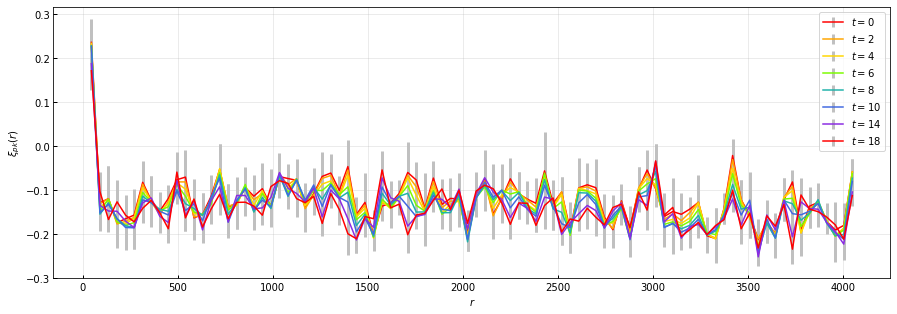

In [68]:
fig, ax = plt.subplots(1, 1, figsize = (15, 5))
colors = cycle((['red', 'orange', 'gold', 'lawngreen', 'lightseagreen', 'royalblue', 'blueviolet']))

for Tmid in [0,2,4,6,8,10,14,18]:
    correlator1D = np.load(data_file_1d(max, Tmid))
    rivolo = np.asarray(correlator1D[1:-1:])
    rrange = np.asarray(xrange[1:-1:])

    ax.errorbar(rrange, rivolo[:,0], yerr=rivolo[:,1], ms=4, color= next(colors), ecolor='silver', elinewidth=3, label=r'$t=$'+str(Tmid))
    print(stat.mean(rivolo[:,0]), stat.stdev(rivolo[:,0]))

    #print([round_to_n(j[0], 5) for j in correlator1D])
    #plot_corr_func(rivoloo, rrange)
ax.set(xlabel=r'$r$', ylabel=r'$\xi_{pk}(r)$')
ax.legend(loc=1, fontsize='medium', fancybox=True)
ax.tick_params(direction='in', width='1')
ax.grid(alpha=0.5, linestyle='-', linewidth=0.5)
plt.savefig(plots_file+'peak_correlator.png')


In [173]:
#print(np.asarray([[rivoloo[i,0], rivolo[i,0]] for i in range(len(rivolo))]))

In [174]:
step = 5
max = 50
xrange = Rrange(xmin, max, step)
trange = Trange(tmin, tmax, tstep)
#correlator2D = spacetime_correlator(all_targets, xrange, step, trange, tstep)
#np.save(data_file_2d(max), correlator2D)
#print('Done')

(21, 10) -0.990617155231153 376.84892861798875


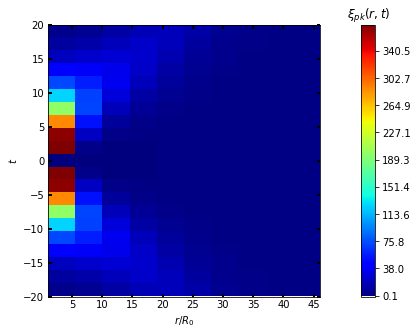

0.1
-1.0 1.15040781505035


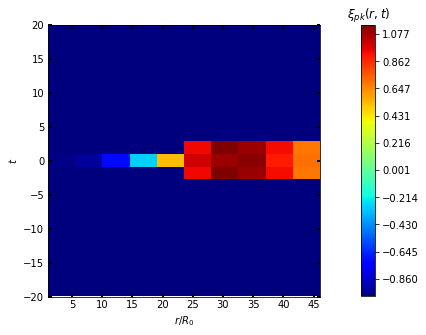

0.575
-1.0 3.4555619262889867


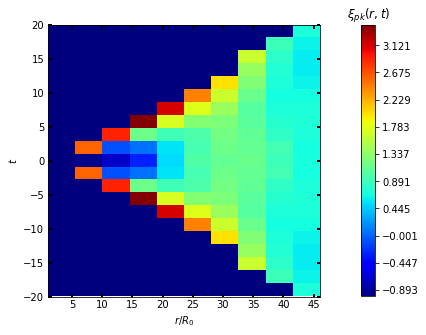

1.05
-1.0 22.106069618352215


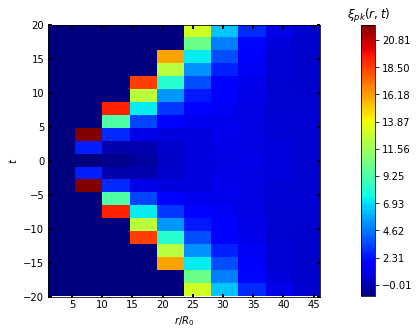

1.525
-1.0 52.51882168088704


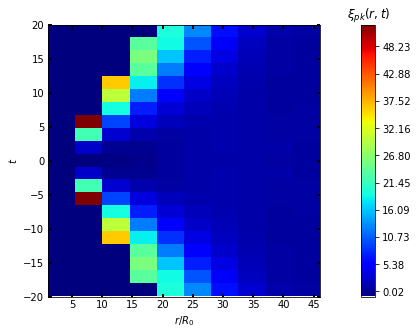

2.0
-1.0 71.81766900551104


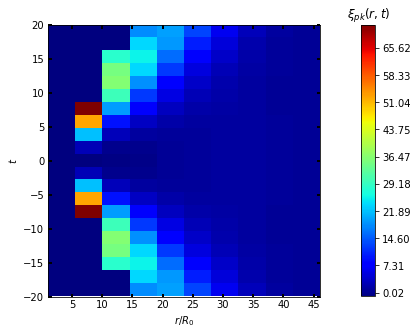

In [175]:
#correlator2D = np.load(data_file_2d(max))
#print(np.shape(correlator2D[0]), correlator2D[1], correlator2D[2])
#plot_2d_corr(hex_list, correlator2D, xrange, step, trange, tstep, False, 0.5)
#for param in np.linspace(0.1, 2, 5):
#    print(param)
#    plot_2d_corr(hex_list, correlator2D, xrange, step, trange, tstep, True, param)